# LSTM on Tully's system

#### Python Coding TangDD 4/10/2021
#### C Coding JiaLY 3/1/2021

### Libraries

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy import random

2022-03-17 15:29:11.182194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public1/home/sc60217/boxhan/g09/g09/bsd:/public1/home/sc60217/boxhan/g09/g09/local:/public1/home/sc60217/boxhan/g09/g09/extras:/public1/home/sc60217/boxhan/g09/g09:/public1/soft/gcc/10.2.0/lib64:/public1/soft/openmpi/3.1.6-intel/lib:/public1/soft/intel/2017/debugger_2017/libipt/intel64/lib:/public1/soft/intel/2017/debugger_2017/iga/lib:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/tbb/lib/intel64/gcc4.7:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/mkl/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2

In [2]:
import matplotlib.pyplot as plt

### Read Data and Generate Dataset

#### FORMAT OF DATASET

       0 1 2  3  4      5      6      7      8        9        10
NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,SPECIAL1,SPECIAL2,SPECIAL3]

In [3]:
# This is a 1 a.u. timestep.
f=open("../reference_50_g2e2_half/result_traj_2.txt",'r')
rawdata=f.readlines()
f.close()

nvel=0
ntraj=0

for i in range(0,len(rawdata)):
    dataline=rawdata[i].split()
    if (len(dataline)>0):
        if (dataline[0]=='VELOC'):
            nvel+=1
        if (dataline[0]=='TRAJ'):
            ntraj+=1 

nele=len(rawdata[-1].split())

In [4]:
print("nvel=",nvel,"ntraj=",ntraj,"nele=",nele)

nvel= 30 ntraj= 1500 nele= 11


In [5]:
all_data_x=[]
all_data_y=[]
elec_value=[]
itraj=-1
for i in range(0,len(rawdata)):
    dataline=rawdata[i].split()
    if (len(dataline)>0):
        if (dataline[0]=='TRAJ'):
            itraj+=1
            all_data_x.append([])
            all_data_y.append([])
    if (len(dataline)>2):
        ele_train=[0,1,2,3,4,5,6,8,9]
        ele_test =[4,5,6]
        #for j in range(nele):
        temp_list=[]
        for j in ele_train:
            temp_list.append(float(dataline[j]))
        all_data_x[itraj].append(temp_list)
        temp_list=[]
        for j in ele_test:
            temp_list.append(float(dataline[j]))
        all_data_y[itraj].append(temp_list)
        elec_value.append(float(dataline[4]))

In [6]:
del rawdata

In [7]:
#elec_value_numpy=np.array(elec_value)
#del elec_value
#elec_max = elec_value_numpy.max()
#elec_min = elec_value_numpy.min()
#elec_avg = np.mean(elec_value_numpy)
#del elec_value_numpy
#print(elec_max,elec_min,elec_avg)

In [8]:
for i in range(itraj):
    print(len(all_data_x[i]),len(all_data_y[i]))

11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11679 11679
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
12166 12166
11488 11488
11488 11488
11488 11488
11488 11488
12326 12326
11488 11488
11703 11703
11329 11329
11488 11488
11488 11488
12080 12080
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
12605 12605
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11930 11930
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
11488 11488
8845 8845
9250 9250
8845 8845
8845 8845
8845 8845
9062 9062
8845 8845
9048 9048
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
9122 9122
8845 8845
9113 9113
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
8845 8845
9084 9084
8845 8845
8845 8845
8845 8845
8845 8845


#### Get a 100-length subset for all trajectories

A minor concern: initial velocity results in different length of trajs.

input_length is the input timelength.

In [9]:
input_length = 50
predict_length = 1

In [10]:
# This is batched data.
all_data_packed_x=[]
all_data_packed_y=[]

# From each trajectory...
for i in range(ntraj):
    #print(int(400./int(i/nvel+4.)))
    #for j in range(0,len(all_data_x[i])-input_length-predict_length,int(400./int(float(i)/float(nvel)+4.0))):
    #    all_data_packed_x.append(all_data_x[i][j:j+input_length])
    #    all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
    for j in range(0,len(all_data_x[i])-input_length-predict_length):
        #"""
        if (j%25==0):
            all_data_packed_x.append(all_data_x[i][j:j+input_length])
            all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        """
        if (i<300):
            if (j%20==0):
                all_data_packed_x.append(all_data_x[i][j:j+input_length])
                all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        else:
            if (j%10==0):
                all_data_packed_x.append(all_data_x[i][j:j+input_length])
                all_data_packed_y.append(all_data_y[i][j+input_length+predict_length-1])
        """
        #start_pop=all_data_x[i][j][4]
        #end_pop  =all_data_x[i][j+input_length-1][4]
        #pop_change = np.abs(end_pop-start_pop)
        #pop_change_list.append(pop_change)
        #if (j%10==0 or pop_change>0.02):
            #all_data_packed_x.append(all_data_x[i][j:j+input_length])
            #all_data_packed_y.append(all_data_y[i][j+input_length:j+input_length+predict_length])
            #all_data_packed_y.append(all_data_y[i][j+input_length+predict_length])


In [11]:
del all_data_x
del all_data_y

In [12]:
nsamp=len(all_data_packed_x)

In [13]:
len(all_data_packed_x[33])

50

In [14]:
all_data_packed_x[9999]

[[-7.021714811,
  0.001508788,
  -0.00062644,
  0.00062644,
  0.98835836,
  0.077930437,
  0.073708608,
  -0.01197251,
  0.01197251],
 [-7.020206012,
  0.001508811,
  -0.000626511,
  0.000626511,
  0.988329158,
  0.078020902,
  0.073806319,
  -0.012001207,
  0.012001207],
 [-7.018697189,
  0.001508834,
  -0.000626581,
  0.000626581,
  0.988299887,
  0.078111433,
  0.073904154,
  -0.012029963,
  0.012029963],
 [-7.017188343,
  0.001508858,
  -0.000626652,
  0.000626652,
  0.98827055,
  0.07820203,
  0.074002114,
  -0.012058779,
  0.012058779],
 [-7.015679473,
  0.001508881,
  -0.000626723,
  0.000626723,
  0.988241144,
  0.078292694,
  0.074100198,
  -0.012087655,
  0.012087655],
 [-7.01417058,
  0.001508905,
  -0.000626794,
  0.000626794,
  0.988211671,
  0.078383423,
  0.074198408,
  -0.01211659,
  0.01211659],
 [-7.012661664,
  0.001508929,
  -0.000626865,
  0.000626865,
  0.988182129,
  0.078474218,
  0.074296742,
  -0.012145585,
  0.012145585],
 [-7.011152723,
  0.001508952,
  -0.0

In [15]:
all_data_packed_y[9999]

[0.986888862, 0.08208601, 0.078747211]

In [16]:
all_data_packed_x[10000]

[[-6.983987678,
  0.001509389,
  -0.000628256,
  0.000628256,
  0.987607758,
  0.080211639,
  0.076189023,
  -0.01270798,
  0.01270798],
 [-6.982478277,
  0.001509414,
  -0.000628332,
  0.000628332,
  0.98757683,
  0.080303722,
  0.076289886,
  -0.012738189,
  0.012738189],
 [-6.98096885,
  0.001509439,
  -0.000628407,
  0.000628407,
  0.987545832,
  0.080395868,
  0.076390877,
  -0.01276846,
  0.01276846],
 [-6.979459398,
  0.001509464,
  -0.000628482,
  0.000628482,
  0.987514763,
  0.080488077,
  0.076491996,
  -0.012798792,
  0.012798792],
 [-6.977949921,
  0.001509489,
  -0.000628558,
  0.000628558,
  0.987483623,
  0.080580349,
  0.076593243,
  -0.012829186,
  0.012829186],
 [-6.976440419,
  0.001509515,
  -0.000628634,
  0.000628634,
  0.987452412,
  0.080672683,
  0.076694618,
  -0.012859642,
  0.012859642],
 [-6.974930892,
  0.00150954,
  -0.00062871,
  0.00062871,
  0.98742113,
  0.08076508,
  0.076796122,
  -0.012890159,
  0.012890159],
 [-6.97342134,
  0.001509565,
  -0.000

#### FORMAT OF DATASET

NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,POSS]

Say, we are planning to feed X(t),V(t),E0(t),E1(t),RHO0(t),ACT(t) into the network, and get RHO0(t+50),ACT(t+50).

In [17]:
dataset_x=np.array(all_data_packed_x)
dataset_y=np.array(all_data_packed_y)

In [18]:
del all_data_packed_x
del all_data_packed_y

In [19]:
dataset_x.shape

(191903, 50, 9)

In [20]:
dataset_y.shape

(191903, 3)

#### Normalize

       0 1       2      3      4             5        6
       0 1 2  3  4      5      6      7      8        9        10
NTRAJ,[X,V,E0.E1.RERHO0,RERHO1,IMRHO1,ACTIVE,SPECIAL1,SPECIAL2,SPECIAL3]

In [21]:
for i in range(nsamp):
    for j in range(input_length):
        dataset_x[i][j][0]=dataset_x[i][j][0]/20.0
        dataset_x[i][j][1]=(dataset_x[i][j][1]*2000-17.0)/30.0
        #dataset_x[i][j][2]=dataset_x[i][j][2]*5.0
        #dataset_x[i][j][3]=dataset_x[i][j][3]*5.0
        #dataset_x[i][j][1]=(dataset_x[i][j][1]*2000-17.0)/30.0
        dataset_x[i][j][2]=dataset_x[i][j][2]*2.5
        dataset_x[i][j][3]=dataset_x[i][j][3]*2.5
        dataset_x[i][j][4]=dataset_x[i][j][4]-0.5
        dataset_x[i][j][5]=dataset_x[i][j][5]
        dataset_x[i][j][6]=dataset_x[i][j][6]
        #dataset_x[i][j][5]=dataset_x[i][j][5]*1.25
        #dataset_x[i][j][6]=dataset_x[i][j][6]*0.25
        #aaa=dataset_x[i][j][4]-0.5
        #dataset_x[i][j][4]=4*aaa*aaa*aaa+0.5*aaa
        #dataset_x[i][j][4]=(dataset_x[i][j][4]-elec_avg)/(elec_max-elec_min)
        #dataset_x[i][j][5]=dataset_x[i][j][5]
        #dataset_x[i][j][6]=dataset_x[i][j][6]
    
for i in range(nsamp):
    dataset_y[i][0]=dataset_y[i][0]-0.5
    #aaa=dataset_y[i][0]-0.5
    #dataset_y[i][0]=4*aaa*aaa*aaa+0.5*aaa
    #dataset_y[i][0]=(dataset_y[i][0]-elec_avg)/(elec_max-elec_min)
    dataset_y[i][1]=dataset_y[i][1]
    dataset_y[i][2]=dataset_y[i][2]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=42)

## Build Model

In [23]:
model = Sequential()
model.add(LSTM(72, activation='tanh', input_shape=(dataset_x.shape[1], dataset_x.shape[2]), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(72, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(72, activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(3, activation='tanh'))
model.compile(optimizer='adam', loss='mse')

2022-03-17 15:31:35.000828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /public1/home/sc60217/boxhan/g09/g09/bsd:/public1/home/sc60217/boxhan/g09/g09/local:/public1/home/sc60217/boxhan/g09/g09/extras:/public1/home/sc60217/boxhan/g09/g09:/public1/soft/gcc/10.2.0/lib64:/public1/soft/openmpi/3.1.6-intel/lib:/public1/soft/intel/2017/debugger_2017/libipt/intel64/lib:/public1/soft/intel/2017/debugger_2017/iga/lib:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/../tbb/lib/intel64_lin/gcc4.4:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/daal/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/tbb/lib/intel64/gcc4.7:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/linux/mkl/lib/intel64_lin:/public1/soft/intel/2017/compilers_and_libraries_2017.5.239/

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 72)            23616     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 72)            41760     
_________________________________________________________________
lstm_2 (LSTM)                (None, 72)                41760     
_________________________________________________________________
dense (Dense)                (None, 3)                 219       
Total params: 107,355
Trainable params: 107,355
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train, y_train, epochs=5, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/5


2022-03-17 15:31:35.377968: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3839/3839 [==============================] - 331s 85ms/step - loss: 2.2729e-04 - val_loss: 2.5046e-05
Epoch 2/5
3839/3839 [==============================] - 324s 84ms/step - loss: 1.4128e-05 - val_loss: 5.4193e-05
Epoch 3/5
3839/3839 [==============================] - 324s 84ms/step - loss: 9.5964e-06 - val_loss: 1.8066e-06
Epoch 4/5
3839/3839 [==============================] - 324s 84ms/step - loss: 5.8972e-06 - val_loss: 2.4795e-05
Epoch 5/5
3839/3839 [==============================] - 324s 84ms/step - loss: 4.9551e-06 - val_loss: 2.6263e-06


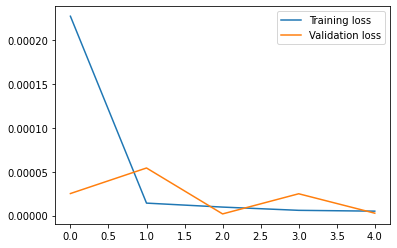

In [26]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [27]:
# So let's check a trajectory...
test_output = model.predict(x_test, verbose=0)

In [28]:
test_output[:,0].shape

(38381,)

In [29]:
y_test[:,0].shape

(38381,)

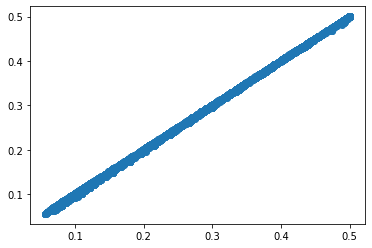

In [30]:
plt.scatter(y_test[:,0],test_output[:,0])

In [40]:
fo=open('tully_out_50_xpos.txt','w')
for ii in range(0,len(y_test.squeeze())):
    fo.write("{0}\t{1}\n".format(y_test[ii][0], test_output[ii][0]))
fo.close()

In [32]:
# Export the model to a SavedModel
model.save('model_half_50', save_format='tf')

2022-03-17 15:59:01.165028: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_half_50/assets


In [33]:
model.save('model_h5_half_50', save_format='h5')

In [34]:
test_output.size

115143

In [35]:
test_output[:,0]

array([0.5002153 , 0.49947122, 0.07319752, ..., 0.4700027 , 0.08880693,
       0.33682686], dtype=float32)

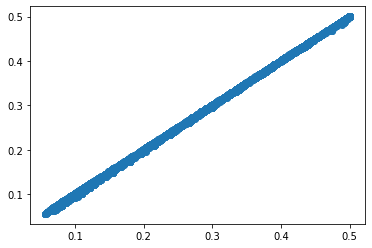

In [36]:
plt.scatter(y_test[:,0],test_output[:,0])

In [41]:
fo=open('tully_out_50_xpos_full.txt','w')
for ii in range(0,len(y_test.squeeze())):
    fo.write("{0}\t{1}\n".format(y_test[ii][0], test_output[ii][0]))
    fo.write("{0}\t{1}\n".format(y_test[ii][1], test_output[ii][1]))
    fo.write("{0}\t{1}\n".format(y_test[ii][2], test_output[ii][2]))
fo.close()

In [38]:
!pwd

/public1/home/sc60217/TangDD_2021/2_LSTM/999_Final/no_deco/tully_3_1/training_g2e2_di


In [39]:
f=open('sample.txt','r')
rawdata=f.readlines()
f.close()

fieldtest_x=np.zeros([1,50,7])

for i in range(50):
    for j in range(7):
        fieldtest_x[0][i][j]=float(rawdata[i].split()[j])

FileNotFoundError: [Errno 2] No such file or directory: 'sample.txt'

In [ ]:
"""
for i in range(1):
    for j in range(50):
        fieldtest_x[i][j][0]=fieldtest_x[i][j][0]/20.0
        fieldtest_x[i][j][1]=(fieldtest_x[i][j][1]*2000-17.0)/30.0
        fieldtest_x[i][j][2]=fieldtest_x[i][j][2]-0.5
"""

In [ ]:
fieldtest_x

In [ ]:
fieldtest_y = model.predict(fieldtest_x, verbose=0)

In [ ]:
fieldtest_y